In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import cPickle as pickle
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit
pd.set_option('notebook_repr_html', False)
pd.set_option('display.max_rows', 20)

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']
from collections import OrderedDict
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models.glyphs import Circle
from bokeh.models import (
    GMapPlot, GMapOptions, Range1d, ColumnDataSource,
    PanTool, WheelZoomTool, BoxZoomTool, BoxSelectTool, ResetTool, PreviewSaveTool, HoverTool)

In [4]:
trips1 = pd.read_csv('Divvy_Trips_2014_Q1Q2.csv')
trips2 = pd.read_csv('Divvy_Trips_2014-Q3-07.csv')
trips3 = pd.read_csv('Divvy_Trips_2014-Q3-0809.csv')
trips4 = pd.read_csv('Divvy_Trips_2014-Q4.csv')
trips_df = pd.concat([trips1, trips2, trips3, trips4]).set_index('trip_id').sort()
stations_df = pd.read_csv('Divvy_Stations_2014-Q3Q4.csv').set_index('id').sort()

def convert_date(time):
    return datetime.strptime(time, '%m/%d/%Y %H:%M')
trips_df.starttime = trips_df.starttime.map(convert_date)
trips_df.stoptime = trips_df.stoptime.map(convert_date)

def get_month(a_datetime):
    return a_datetime.date().month
trips_df['startmonth'] = trips_df.starttime.map(get_month)

#pickle.dump(trips_df, open('trips_2014.pickle', 'wb'))
#pickle.dump(stations_df, open('stations_2014.pickle', 'wb'))

In [ ]:
bikeids = trips_df.bikeid.unique()
bikeids.sort()
trips_by_month = [trips_df[trips_df.startmonth==month+1] for month in range(12)]

gaptimes_by_month_bikeid = {month: {} for month in range(12)}
gaptimes_by_month = {month: [] for month in range(12)}
gaptimes_by_bikeid = {bikeid: [] for bikeid in bikeids}

for month in range(12):
    all_trips = trips_by_month[month]
    for bikeid in bikeids:
        trips = all_trips[all_trips.bikeid==bikeid]
        starttimes = trips.starttime.values[1:]
        stoptimes = trips.stoptime.values[:-1]
        gaptimes = (starttimes-stoptimes).astype(float)/10**9/3600
        
        gaptimes_by_month_bikeid[month][bikeid] = gaptimes
        gaptimes_by_month[month] = np.concatenate((gaptimes_by_month[month], gaptimes))
        gaptimes_by_bikeid[bikeid] = np.concatenate((gaptimes_by_bikeid[bikeid], gaptimes))

#pickle.dump(gaptimes_by_month_bikeid, open('gaptimes_by_month_bikeid.pickle', 'wb'))
#pickle.dump(gaptimes_by_month, open('gaptimes_by_month.pickle', 'wb'))
#pickle.dump(gaptimes_by_bikeid, open('gaptimes_by_bikeid.pickle', 'wb'))

In [ ]:
trips_df = pickle.load(open('trips_2014.pickle', 'rb'))
stations_df = pickle.load(open('stations_2014.pickle', 'rb'))
gaptimes_by_month_bikeid = pickle.load(open('gaptimes_by_month_bikeid.pickle', 'rb'))
gaptimes_by_month = pickle.load(open('gaptimes_by_month.pickle', 'rb'))
gaptimes_by_bikeid = pickle.load(open('gaptimes_by_bikeid.pickle', 'rb'))

print len(trips_df), len(stations_df)

In [14]:
def func(t, tau, A):
    return A*np.exp(-t/tau)

taus = []
As = []
for month in range(12):
    gaptimes = gaptimes_by_month[month]
    data = gaptimes[(gaptimes>0.5) & (gaptimes<4.5)]

    hist_data = np.histogram(data, bins=16)
    xs = (hist_data[1][:-1]+hist_data[1][1:])/2
    ys = hist_data[0]
    tau, A = curve_fit(func, xs, ys, p0=[2.0, 1000])[0]
    taus.append(tau)
    As.append(A)

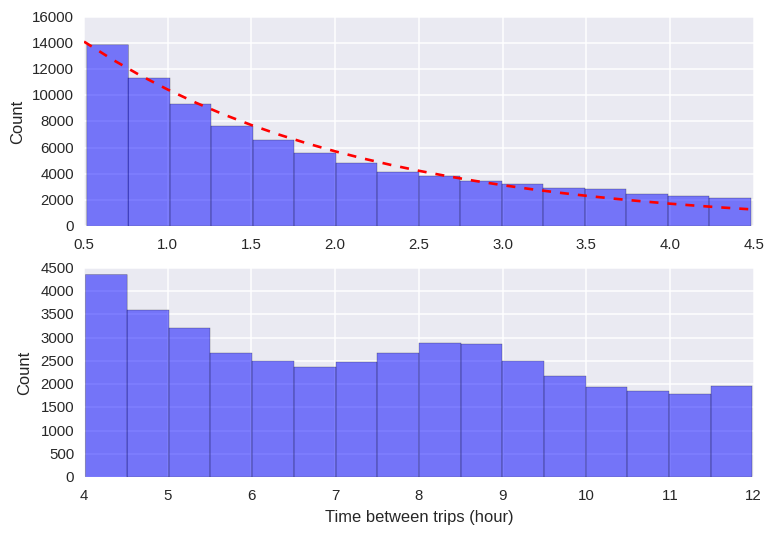

In [15]:
month = 9
gaptimes = gaptimes_by_month[month]
short_data = gaptimes[(gaptimes>0.5) & (gaptimes<4.5)]
long_data = gaptimes[(gaptimes>4) & (gaptimes<12)]

plt.subplot(2,1,1)
plt.hist(short_data, bins=16, alpha=0.5, color='b')
xs0 = np.linspace(0.5, 4.5, 25)
plt.plot(xs0, func(xs0, taus[month], As[month]),'r--')
plt.xlim(0.5, 4.5)
#plt.xlabel('Time between trips (hour)')
plt.ylabel('Count')

plt.subplot(2,1,2)
plt.hist(long_data, bins=16, alpha=0.5, color='b')
plt.xlim(4, 12)
#plt.ylim(3000, 6500)
plt.xlabel('Time between trips (hour)')
plt.ylabel('Count')
plt.show()

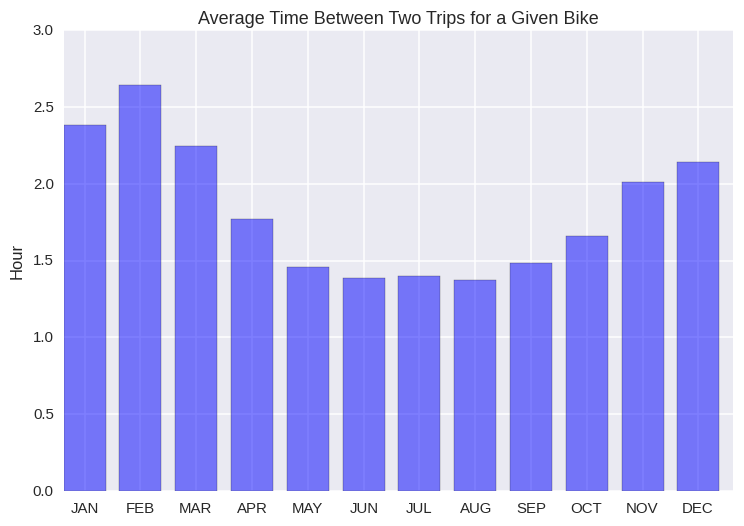

In [16]:
index = np.arange(12)
bar_width = 0.75
plt.bar(index, taus, bar_width, color='b', alpha=0.5)
plt.title('Average Time Between Two Trips for a Given Bike')
plt.ylabel('Hour')
plt.xticks(index+bar_width/2, ('JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
plt.show()

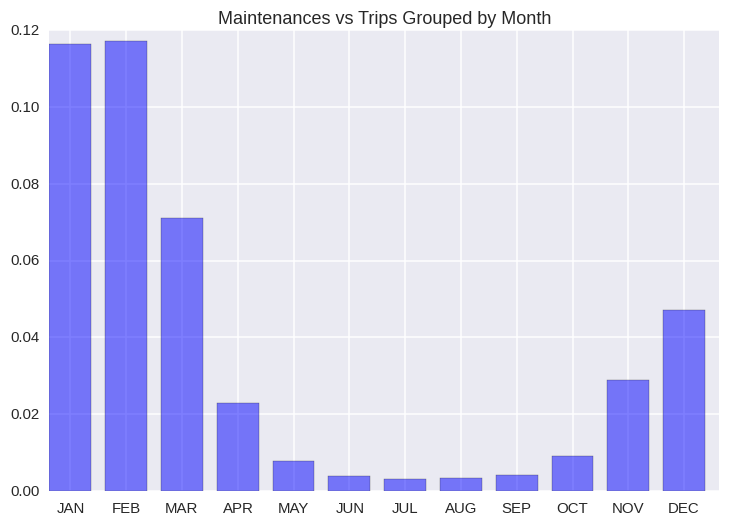

In [17]:
cutoff = 72.0
service_nums_by_month = []
trip_nums_by_month = []
for month in range(12):
    service_nums_by_month.append(float(len(filter(lambda x: x>cutoff, gaptimes_by_month[month]))))
    trip_nums_by_month.append(len(trips_df[trips_df.startmonth==month+1]))

index = np.arange(12)
bar_width = 0.75
plt.bar(index, np.array(service_nums_by_month)/np.array(trip_nums_by_month), bar_width, color='b', alpha=0.5)
plt.title('Maintenances vs Trips Grouped by Month')
plt.ylabel('')
plt.xticks(index+bar_width/2, ('JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
plt.show()

In [18]:
bikeids = list(set(trips_df.bikeid))
trip_nums_by_bikeid = trips_df.groupby('bikeid')['tripduration'].count()
service_nums_by_bikeid = np.array([len(gaptimes_by_bikeid[bikeid][gaptimes_by_bikeid[bikeid]>cutoff]) for bikeid in bikeids])

bikes_df = pd.DataFrame({
        'bikeid': bikeids,
        'trip_num': trip_nums_by_bikeid,
        'service_num': service_nums_by_bikeid,
        'norm_service_num': service_nums_by_bikeid/trip_nums_by_bikeid,
}).set_index('bikeid')

Pearson correlation: (0.24179074802533804, 9.573358480022131e-41)


/home/chenyu/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


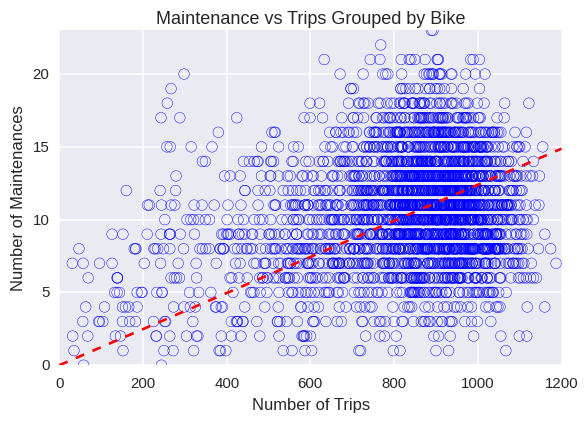

In [22]:
print 'Pearson correlation:', stats.pearsonr(bikes_df.trip_num, bikes_df.service_num)
def func0(x, k, b):
    return np.multiply(k, x)+0*b
popt0, pcov0 = curve_fit(func0, bikes_df.trip_num, bikes_df.service_num)
xs0 = np.linspace(0, 1200, 2)
plt.plot(xs0, func0(xs0, popt0[0], popt0[1]), 'r--')
plt.scatter(bikes_df.trip_num, bikes_df.service_num, s=50, facecolors='None', edgecolors='b')
plt.xlabel('Number of Trips')
plt.ylabel('Number of Maintenances')
plt.xlim(0, 1200)
plt.ylim(0, 23)
plt.title('Maintenance vs Trips Grouped by Bike')
plt.show()

In [23]:
lons = stations_df.longitude
lats = stations_df.latitude
names = stations_df.name
services = stations_df.service
min_service = stations_df.service.min()
max_service = stations_df.service.max()
colors = ["#%02x%02x%02x" % (200*(r-min_service)/(max_service-min_service)+55, 
                             0,
                             255*(max_service-r)/(max_service-min_service))
          for r in stations_df.service]


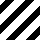
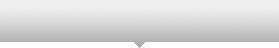
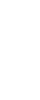
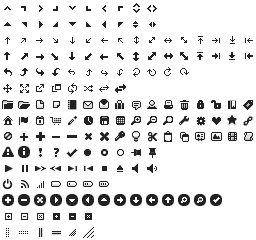
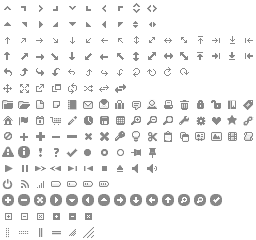
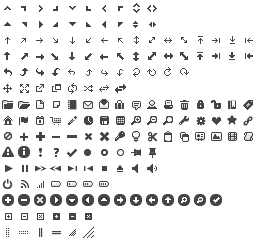
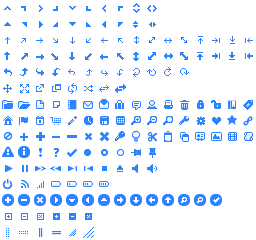
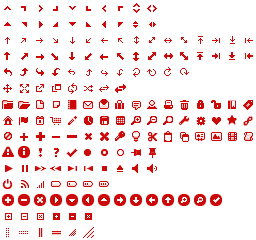
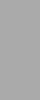
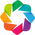
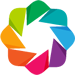
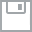
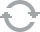
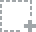
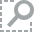
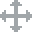
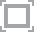
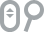

In [24]:
output_notebook()
map_options = GMapOptions(lat=41.8827, 
                          lng=-87.6227, 
                          map_type="roadmap", 
                          zoom=11)
plot = GMapPlot(x_range=Range1d(), 
                y_range=Range1d(), 
                map_options=map_options, 
                title="Maintences vs Trips Grouped by Station")
plot.add_tools(PanTool(), 
               WheelZoomTool(), 
               BoxZoomTool(), 
               BoxSelectTool(), 
               ResetTool(), 
               PreviewSaveTool(), 
               HoverTool())
source = ColumnDataSource(
    data = dict(x = lons, 
                y = lats, 
                radius = [10]*300, 
                color = colors, 
                name = names, 
                service = services))
circle = Circle(x="x", 
                y="y", 
                size="radius", 
                fill_color="color", 
                line_color=None, 
                fill_alpha=1)
plot.add_glyph(source, circle)
hover = plot.select(dict(type=HoverTool))
hover.point_policy = "follow_mouse"
hover.tooltips = OrderedDict([("Station", "@name"), 
                              ("Maintenance", "@service times per trip")])
show(plot)